<a href="https://colab.research.google.com/github/sogand73/OCT-Classification/blob/main/oct_classification_(CNV_%2C_DME%2C_DRUSEN_%2C_NORMAL)_using_dictionary_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#The last edit and results (01.09.2024):
#The models were applied to the Retinal OCT with 4 categories of diseases (CNV, DME, DRUSEN, NORMAL) :
#Dataset is used in the paper "Classification of optical coherence tomography images using a capsule network" (Authors: Takumasa Tsuji, Yuta Hirose, Kohei Fujimori, 2020)
#The paper link: https://bmcophthalmol.biomedcentral.com/articles/10.1186/s12886-020-01382-4
#Dataset Link: https://www.kaggle.com/datasets/paultimothymooney/kermany2018/
#Dataset has about 84000 training images, so we have a RAM problem during dataset loading and training.
#With a few numbers of data, all models had bad results (accuracy of about 0.27) on training and test data.

#Next work:
#Using more data
#work on size reduction part during data loading, which makes some information be missed
#Using more dictionary atoms
#Using more complex methods for atom selection and feature extraction
#Improving DNN model architectures
#Check and select the best parameters of Dictionary learning and DNN models training processes

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import MiniBatchDictionaryLearning

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp /kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download paultimothymooney/kermany2018/

100% 10.8G/10.8G [08:03<00:00, 27.4MB/s]
100% 10.8G/10.8G [08:03<00:00, 24.1MB/s]


In [ ]:
!unzip kermany2018.zip

In [34]:
import os
import cv2

%cd /content/OCT2017 /

train_path = "/content/OCT2017 /train/"
#val_path = "/content/OCT2017 /val/"
test_path = "/content/OCT2017 /test/"

classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']


def load(path,num):
    # List to store images and labels
    listed_paths = []
    images = []
    labels = []

    for i in classes:
        base_path = os.path.join(path, i)
        imgs = os.listdir(base_path)
        for img in imgs[:num]:
            img_path = base_path + '/' + img
            listed_paths.append(img_path)
            image = cv2.imread(img_path)
            image = image[:,:,0]
            image = cv2.resize(image, (256, 256)) #256*256*1 pixels
            images.append(image.flatten())
            labels.append(i)
    return np.array(listed_paths), np.array(images), np.array(labels)

train_paths, train_images, train_labels = load(train_path,1000)
#val_paths, val_images, val_labels = load(val_path,100)
test_paths, test_images, test_labels = load(test_path,200)

# Splitting the data into training and validating sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)



/content/OCT2017 


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
X_train, X_test, X_val, y_train, y_test, y_val = train_images, test_images, val_images, train_labels, test_labels, val_labels

In [39]:
# Perform dictionary learning on training data
dl = MiniBatchDictionaryLearning(n_components=30, alpha=1, n_iter=20, batch_size=30)
X_train_transformed = dl.fit_transform(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:2303: FutureWarning: 'n_iter' is deprecated in version 1.1 and will be removed in version 1.4. Use 'max_iter' and let 'n_iter' to its default value instead. 'n_iter' is also ignored if 'max_iter' is specified.
  warnings.warn(


In [40]:
# Transform validation and test data using the learned dictionary
X_val_transformed = dl.transform(X_val)
X_test_transformed = dl.transform(X_test)


In [38]:
# Identifying Discriminative Atoms: When we want to select discriminative atoms as features for data dimension reduction

coefficients = dl.transform(X_train) #The result is equal to: X_train_transformed = dl.fit_transform(X_train)

# Assuming dl.components_ contains the learned dictionary components (atoms)
learned_dictionary = dl.components_
learned_dictionary.shape

# Assuming 'y_train' contains the corresponding labels for the train data
# Let's say class 0 and class 1 are represented by labels 0 and 1, respectively

# Separate coefficients for each class
# 1 : CNV, 2 : DME, 3 : DRUSEN, 4 : NORMAL
class_1_coeffs = coefficients[y_train == "CNV"]  # Coefficients for class CNV
class_2_coeffs = coefficients[y_train == "DME"]  # Coefficients for class DME
class_3_coeffs = coefficients[y_train == "DRUSEN"]  # Coefficients for class DRUSEN
class_4_coeffs = coefficients[y_train == "NORMAL"]  # Coefficients for class NORMAL

#print(f"size of class 1 coeff.:{class_1_coeffs.shape}, \nsize of class 2 coeff.:{class_2_coeffs.shape}")

# Calculate average coefficients for each class
avg_coeffs_class_1 = np.mean(class_1_coeffs, axis=0)
avg_coeffs_class_2 = np.mean(class_2_coeffs, axis=0)
avg_coeffs_class_3 = np.mean(class_3_coeffs, axis=0)
avg_coeffs_class_4 = np.mean(class_4_coeffs, axis=0)

#print(f"size of average class 1 coeff.:{avg_coeffs_class_1.shape}, {avg_coeffs_class_1} \nsize of average class 2 coeff.:{avg_coeffs_class_2.shape}, {avg_coeffs_class_2}")

# Find discriminative atoms by comparing average coefficients
threshold = 0.5  # You can adjust this threshold as needed

# Identifying discriminative atoms for class 1
discriminative_atoms_class_1 = np.where(avg_coeffs_class_1 > threshold)[0]

# Identifying discriminative atoms for class 2
discriminative_atoms_class_2 = np.where(avg_coeffs_class_2 > threshold)[0]

# Identifying discriminative atoms for class 3
discriminative_atoms_class_3 = np.where(avg_coeffs_class_3 > threshold)[0]

# Identifying discriminative atoms for class 4
discriminative_atoms_class_4 = np.where(avg_coeffs_class_4 > threshold)[0]

# Display or further analyze the discriminative atoms
print("Discriminative Atoms for Class 1:", discriminative_atoms_class_1)
print("Discriminative Atoms for Class 2:", discriminative_atoms_class_2)
print("Discriminative Atoms for Class 3:", discriminative_atoms_class_3)
print("Discriminative Atoms for Class 4:", discriminative_atoms_class_4)

# Extract discriminative atoms from the learned dictionary
#extracted_atoms = learned_dictionary[np.union1d(discriminative_atoms_class_1, discriminative_atoms_class_2, discriminative_atoms_class_3, discriminative_atoms_class_4)]

combined_atoms = np.concatenate((discriminative_atoms_class_1, discriminative_atoms_class_2, discriminative_atoms_class_3, discriminative_atoms_class_4))

# Compute union of unique elements
extracted_atoms = learned_dictionary[np.unique(combined_atoms)]

# Transform the original data using the extracted discriminative atoms
X_train_transformed_discriminative = np.dot(X_train, extracted_atoms.T)  # Transforming data by dot product with extracted atoms
X_test_transformed_discriminative = np.dot(X_test, extracted_atoms.T)
X_val_transformed_discriminative = np.dot(X_val, extracted_atoms.T)

#Replece train and test and validation data with data transformed using discriminative atoms
X_train_transformed = X_train_transformed_discriminative
X_test_transformed = X_test_transformed_discriminative
X_val_transformed = X_val_transformed_discriminative

Discriminative Atoms for Class 1: [ 0  1  4  5  6  7  9 10 12 14 17 26 27 29]
Discriminative Atoms for Class 2: [ 0  4  5  6  7  8  9 12 13 14 17 20 24 25 26 27 29]
Discriminative Atoms for Class 3: [ 0  1  6  7  9 12 13 14 17 20 26 27 29]
Discriminative Atoms for Class 4: [ 0  6  7  9 10 12 14 17 26 27]


In [26]:
# Using logistic regression for classification
classifier = LogisticRegression()
classifier.fit(X_train_transformed, y_train)

# Predicting on test data
predictions = classifier.predict(X_test_transformed)

# Evaluating the classifier
accuracy = classifier.score(X_test_transformed, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.2725


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
# Step 3: Build Deep Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelBinarizer

# Define the DNN architecture
model_FC = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_transformed.shape[1],)),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')  # 4 output classes
])

# Compile the model
model_FC.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


#Apply one-hot encoding for labels of the multi-class classification problem
# Initialize LabelBinarizer
label_binarizer = LabelBinarizer()

# Fit and transform the string-format labels to one-hot encoded format
y_train_FC = label_binarizer.fit_transform(train_labels)
y_test_FC = label_binarizer.fit_transform(test_labels)
y_val_FC = label_binarizer.fit_transform(val_labels)


In [28]:
# Step 4: Training and Evaluation
from keras.callbacks import History
history = History()

model_FC.fit(X_train_transformed, y_train_FC, epochs=20, batch_size=32, validation_data=(X_val_transformed, y_val_FC), callbacks=[history])

# Evaluate the model
test_loss, test_accuracy = model_FC.evaluate(X_test_transformed, y_test_FC)
print(f'Test accuracy: {test_accuracy}')


Epoch 1/20
50/50 [==============================] - 1s 8ms/step - loss: 552.6462 - accuracy: 0.2456 - val_loss: 289.5491 - val_accuracy: 0.2150
Epoch 2/20
50/50 [==============================] - 0s 3ms/step - loss: 211.8653 - accuracy: 0.2544 - val_loss: 208.6814 - val_accuracy: 0.2725
Epoch 3/20
50/50 [==============================] - 0s 4ms/step - loss: 188.9038 - accuracy: 0.2663 - val_loss: 129.8708 - val_accuracy: 0.2775
Epoch 4/20
50/50 [==============================] - 0s 4ms/step - loss: 178.4353 - accuracy: 0.2694 - val_loss: 138.5881 - val_accuracy: 0.2625
Epoch 5/20
50/50 [==============================] - 0s 4ms/step - loss: 200.7488 - accuracy: 0.2669 - val_loss: 177.4524 - val_accuracy: 0.2575
Epoch 6/20
50/50 [==============================] - 0s 3ms/step - loss: 151.8439 - accuracy: 0.2625 - val_loss: 150.7449 - val_accuracy: 0.2725
Epoch 7/20
50/50 [==============================] - 0s 3ms/step - loss: 135.9048 - accuracy: 0.2681 - val_loss: 185.6600 - val_accuracy:

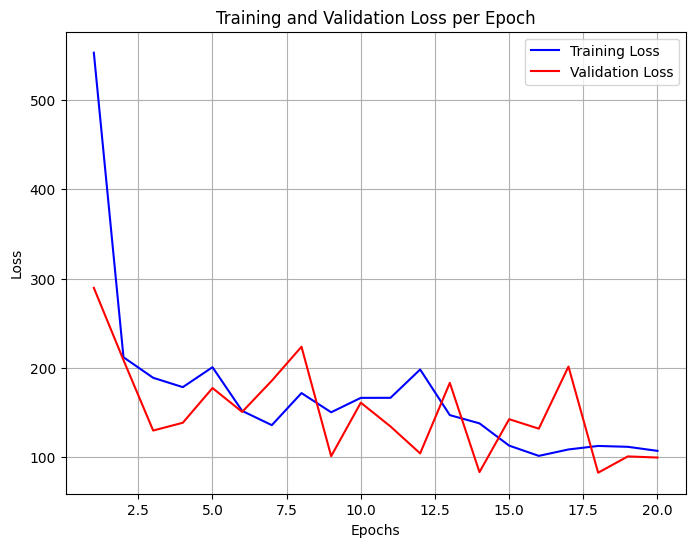

In [30]:
import matplotlib.pyplot as plt

# Access loss values from training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Get the number of epochs
epochs = range(1, len(training_loss) + 1)

# Plotting the loss per epoch for training and validation data
plt.figure(figsize=(8, 6))
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()
model_FC.history


In [31]:
# Reshape the transformed data from vector to image format

def vector_to_image(data_vector):
  image_height = data_vector.shape[1]
  image_width = 1
  num_channels = 1

  data_image = []
  for i in range(data_vector.shape[0]):
    single_img_reshaped = data_vector[i].reshape(-1, image_height, image_width)
    data_image.append(single_img_reshaped)

  data_image = np.array(data_image)
  data_image.resize(data_vector.shape[0],32,32,num_channels)
  return data_image

X_train_transformed_reshaped = vector_to_image(X_train_transformed)
X_test_transformed_reshaped = vector_to_image(X_test_transformed)
X_val_transformed_reshaped = vector_to_image(X_val_transformed)

In [32]:
#CNN model for classification
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.preprocessing import LabelBinarizer

#Define train and test and validation data
X_train_CNN = X_train_transformed_reshaped
X_test_CNN = X_test_transformed_reshaped
X_val_CNN = X_val_transformed_reshaped

#Apply one-hot encoding for labels of the multi-class classification problem
# Initialize LabelBinarizer
label_binarizer = LabelBinarizer()

# Fit and transform the string-format labels to one-hot encoded format
y_train_CNN = label_binarizer.fit_transform(train_labels)
y_test_CNN = label_binarizer.fit_transform(test_labels)
y_val_CNN = label_binarizer.fit_transform(val_labels)


#Define dimensions
image_height = X_train_CNN.shape[1]
image_width = X_train_CNN.shape[2]
num_channels = X_train_CNN.shape[3]

# Define the CNN architecture
model = Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(image_height, image_width, num_channels)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dense(32, activation='relu'),
    Flatten(),
    Dense(4, activation='softmax')  # 4 output classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train the CNN using transformed data
model.fit(X_train_CNN, y_train_CNN, epochs=10, batch_size=16, validation_data=(X_val_CNN, y_val_CNN))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_CNN, y_test_CNN)
print(f'Test accuracy: {test_accuracy}')


Epoch 1/10
100/100 [==============================] - 11s 96ms/step - loss: 66.8930 - accuracy: 0.2356 - val_loss: 23.1808 - val_accuracy: 0.2150
Epoch 2/10
100/100 [==============================] - 6s 56ms/step - loss: 8.5343 - accuracy: 0.2600 - val_loss: 6.9700 - val_accuracy: 0.2175
Epoch 3/10
100/100 [==============================] - 6s 62ms/step - loss: 4.5639 - accuracy: 0.2587 - val_loss: 4.1299 - val_accuracy: 0.2175
Epoch 4/10
100/100 [==============================] - 8s 75ms/step - loss: 2.4822 - accuracy: 0.2500 - val_loss: 2.0877 - val_accuracy: 0.2150
Epoch 5/10
100/100 [==============================] - 6s 56ms/step - loss: 1.4068 - accuracy: 0.2587 - val_loss: 1.3875 - val_accuracy: 0.2200
Epoch 6/10
100/100 [==============================] - 9s 89ms/step - loss: 1.3862 - accuracy: 0.2575 - val_loss: 1.3879 - val_accuracy: 0.2200
Epoch 7/10
100/100 [==============================] - 7s 67ms/step - loss: 1.3862 - accuracy: 0.2575 - val_loss: 1.3882 - val_accuracy: 0.2